#  <font color='dark gary'> Anomaly detection method
https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
<img src = 'https://sdk.finance/wp-content/uploads/2021/04/anomaly_detection-768x512.png'>

### 1. Supervised learning
### 2. Semi-Supervised learning (Novelty detection)
- 새로운 한번도 보지 못한 데이터가 outlier인지 아닌지 판단(훈련데이터에 outlier가 없음)

### 3. Unsupervised learning (Outlier detection)
- inlier와 outlier를 포함한 훈련데이터에서 outliers를 탐색
        * Anomaly는 outlier와 novelty를 모두 호칭

https://github.com/yzhao062/anomaly-detection-resources
- 응용 분야
     * Data cleaning
     * Fraud detection like credit card frauds or security breaches
     * Health monitoring of people, systems, and machines

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 
get_ipython().run_line_magic('matplotlib', 'inline')

# <font color='red'> 1. Supervised Learning

In [27]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## 1.1 Interquartile Range(IQR) - Box plot으로 outlier 탐색
단일 변수의 백분위수 (range)를 확인하여 이상치(outlier)를 그려보고 확인한다

<AxesSubplot:>

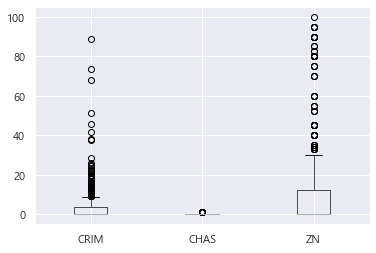

In [28]:
cols = ['CRIM','CHAS','ZN']
boston.boxplot(column=cols)

In [29]:
def Outliers(col):
    q1, q3 =col.quantile(0.15), col.quantile(0.95)
    iqr = q3 - q1
    l_fence, u_fence = q1 - 1.5*iqr , q3 + 1.5*iqr  
    outliers = col[(col < l_fence) | (col > u_fence)] 
    if outliers.count() > 0 :
        print(col.name,'의 총 이상치 관측 수:', outliers.count())
        print('Lower fence: ', l_fence, 'Upper fence: ', u_fence) #filtering = col.drop(outliers.index, axis = 0)
        
for col in boston.columns:
    Outliers(boston[col])

CRIM 의 총 이상치 관측 수: 6
Lower fence:  -23.5568 Upper fence:  39.39672
B 의 총 이상치 관측 수: 48
Lower fence:  264.29375000000005 Upper fence:  476.4637499999999


## 1.2 확률밀도함수로 이상치 확인

단일변수의 확률밀도 함수를 확인하여 이상치를 p-value로 확인한다

z = 1.96의 pdf: 0.942, z = 2.58의 pdf: 0.986


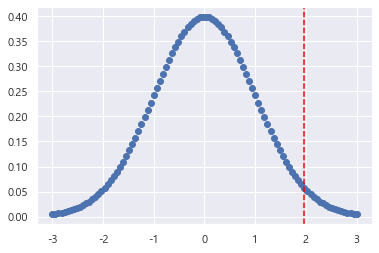

In [30]:
import scipy as sp
sp.stats.norm(loc=0, scale=1) # 평균0, 표준편차 1
rv = sp.stats.norm(loc=0, scale=1)
print(f'z = 1.96의 pdf: {1- rv.pdf(1.96):.3f}, z = 2.58의 pdf: {1- rv.pdf(2.58):.3f}')
plt.scatter(np.linspace(-3,3,100), rv.pdf(np.linspace(-3,3,100)))
plt.axvline(x=1.96, color='red', linestyle='--')

Text(0.5, 0, 'instances')

Text(0, 0.5, 'pdf(probability density function)')

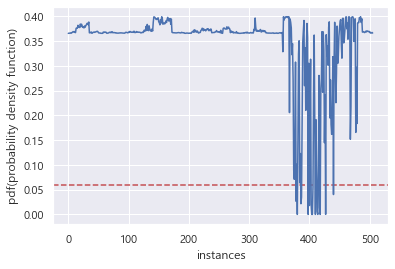

In [31]:
z = (boston['CRIM'] - boston['CRIM'].mean())/boston['CRIM'].std()
plt.axhline(y= rv.pdf(1.96), color='r', linestyle='--')
plt.plot(rv.pdf(z))
plt.xlabel('instances'); plt.ylabel('pdf(probability density function)')

## 1.3 Kernel Density Estimation 이상치 확인

In [32]:
from sklearn.neighbors import KernelDensity
kern_dens = KernelDensity()
X = boston['CRIM'].values.reshape(-1,1)
kern_dens.fit(X)

KernelDensity()

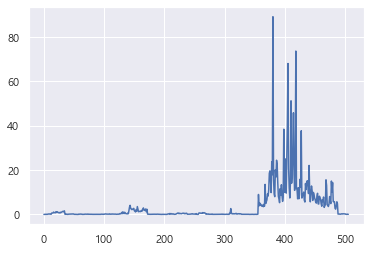

In [33]:
scores = kern_dens.score_samples(X)
plt.plot(X)

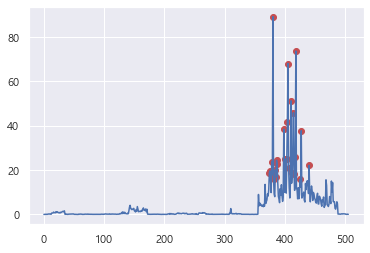

In [34]:
threshold = np.quantile(scores, .05)
idx = np.where(scores <= threshold)
values = X[idx]
x_ax= range(len(X)) 
plt.plot(x_ax, X)
plt.scatter(idx,values, color='r')
plt.show()

## 1.4 K-Nearest neighbors 이상치 확인
- Unsupervised K-Nearest Neighbors
- https://scikit-learn.org/stable/modules/neighbors.html
- SVM도 SVM hyperplane에서 거리를 기준으로 이상치 확인 가능

NearestNeighbors(n_neighbors=3)

<AxesSubplot:>

Text(0.5, 1.0, 'Distance mean of KNN')

Text(0.5, 0, 'Instances')

Text(0, 0.5, 'Mean of Distance')

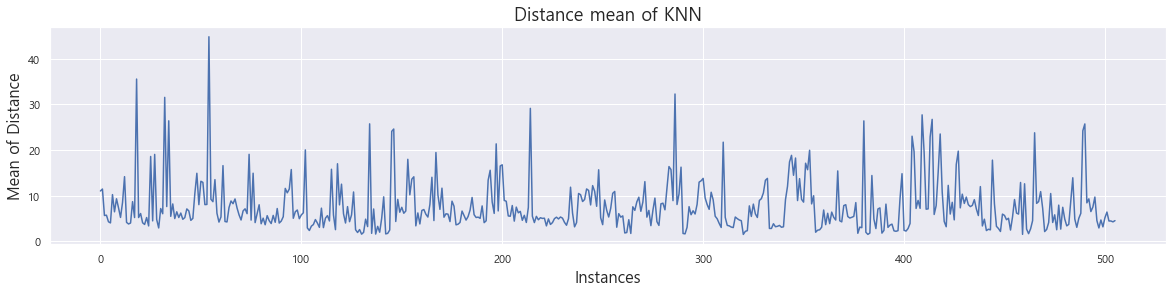

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
54,0.0136,75.0,4.0,0.0,0.41,5.888,47.6,7.3197,3.0,469.0,21.1,396.9,14.8


In [35]:
from sklearn.neighbors import NearestNeighbors
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
nbrs = NearestNeighbors(n_neighbors = 3)
nbrs.fit(boston)
distances, indices = nbrs.kneighbors(boston) # distances : distances between data points
                                           # indices : associated index values
pd.Series(distances.mean(axis =1)).plot(figsize=(20,4))
plt.title('Distance mean of KNN', fontsize = 18)
plt.xlabel('Instances', fontsize = 16); plt.ylabel('Mean of Distance', fontsize = 16)
plt.show()

outlier_index = np.where(distances.mean(axis = 1) > 40.0)
boston.iloc[outlier_index]

### 불균형데이터 유형
- 이상치는 극히 심한 불균형데이터와 같은 유형을 갖는다.
- make_classification() 함수에 클라스를 무작위로 교환하여 분류를 어렵게 함, flip_y=0

### 단변량으로 시각화하면 이상치를 발견하기 어려움

<Figure size 1440x288 with 0 Axes>

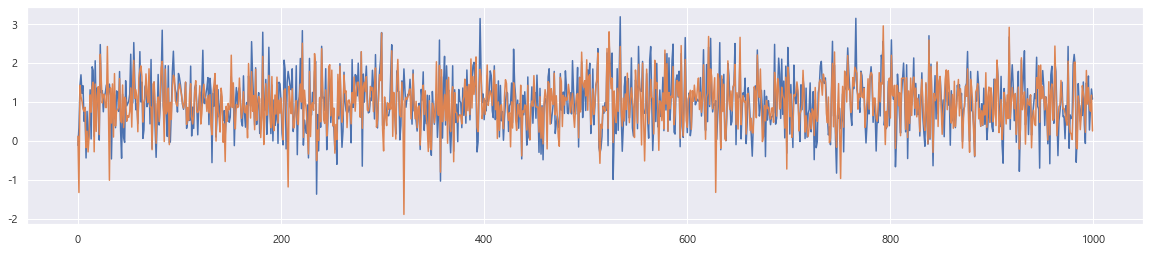

In [36]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
plt.figure(figsize=(20,4))
plt.plot(X[:, 0]); plt.plot(X[:, 1])

### 다변량, combination으로 시각화하면 이상치를 발견할 수있음

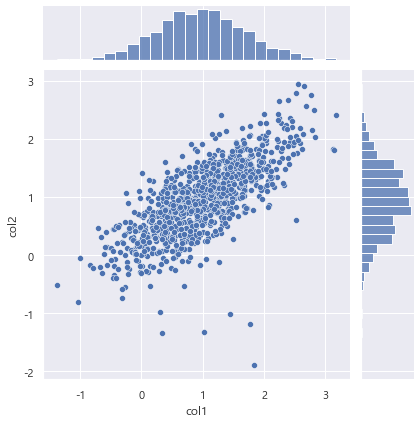

In [37]:
data= pd.DataFrame(X, columns=['col1', 'col2'])
sns.jointplot(data=data, x='col1', y='col2')

## 1.5 EllipticEnvelope 이상치 확인
- https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html
- 다변량 특성이 가우시안분포를 한다고 하면 다변량 특성의 공분산을 이용하여 Outliers를 탐지 (다양한 거리 적용 가능)
- 이상치 Threshold는 과거 경험상 contamination=0.01, 즉 1%가 있다고 가정(연구자가 임의로 설정)

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'col1')

Text(0, 0.5, 'col2')

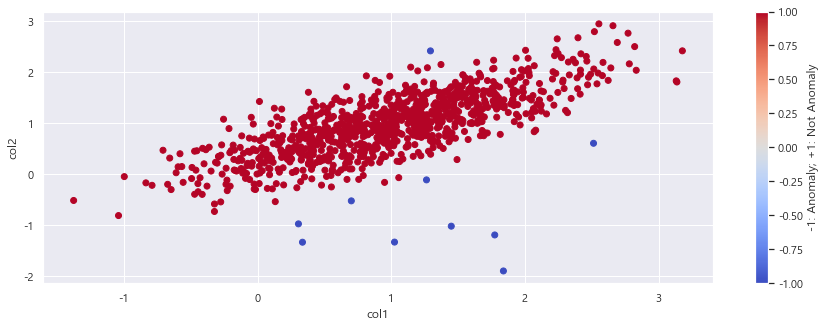

In [40]:
from sklearn.covariance import EllipticEnvelope
data= pd.DataFrame(X, columns=['col1', 'col2'])
el = EllipticEnvelope(contamination=0.01, random_state=0)

data['Anomaly or Not'] = el.fit(data).predict(data)
plt.figure(figsize = (15, 5))
ax = plt.scatter(data['col1'], data['col2'], c = data['Anomaly or Not'], cmap = 'coolwarm')
plt.xlabel('col1'); plt.ylabel('col2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')

## 1.6  PCA with EllipticEnvelope anomaly

X.shape : (1000, 10)


Text(0.5, 0, '# of PCA')

Text(0, 0.5, 'Cumulative ratio of total variance')

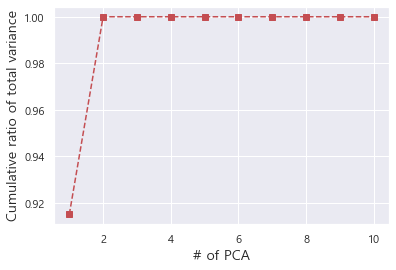

In [41]:
from sklearn.decomposition import PCA
X, y = make_classification(n_samples=1000, n_features=10, n_redundant=8,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
print(f'X.shape : {X.shape}')
pca = PCA().fit(X)
plt.plot(np.arange(1, X.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), 'rs--')
plt.xlabel('# of PCA', fontsize='14'); plt.ylabel('Cumulative ratio of total variance', fontsize='14')

EllipticEnvelope(contamination=0.01, random_state=0)

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'pca_1')

Text(0, 0.5, 'pca_2')

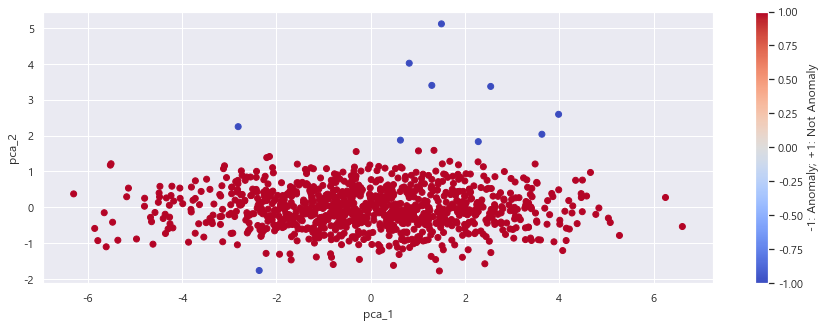

In [42]:
X_pca = PCA(n_components=2).fit(X).transform(X)
X_pca = pd.DataFrame(X_pca, columns= ['pca_1', 'pca_2'])
plt.rcParams['axes.unicode_minus'] = False

el.fit(X_pca)

X_pca['Anomaly or Not'] = el.predict(X_pca)
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (15, 5))
ax = plt.scatter(X_pca['pca_1'], X_pca['pca_2'], c = X_pca['Anomaly or Not'], cmap = 'coolwarm')
plt.xlabel('pca_1'); plt.ylabel('pca_2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')

## 1.7 Robust covariance estimation and Mahalanobis distances relevance
https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html

In [13]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
n_outliers = np.sum(y) # int(X.shape[0]*0.01), outlier의 개수
n_samples = X.shape[0]

robust_cov = MinCovDet().fit(X) # fit a MCD robust estimator to data
emp_cov = EmpiricalCovariance().fit(X) # fit a MLE estimator to data
pd.DataFrame(robust_cov.covariance_)

,0,1,2,3,4,5,6,7,8,9
0,0.463372,0.114468,-0.552623,0.276878,-0.426450,-0.065298,0.354362,0.357781,-0.013035,0.304207
1,0.114468,0.076293,-0.122751,0.026614,-0.098631,-0.066877,0.110675,0.115787,0.005672,0.091507
2,-0.552623,-0.122751,0.663012,-0.342186,0.510516,0.063328,-0.415985,-0.418839,0.018094,-0.358112
3,0.276878,0.026614,-0.342186,0.201803,-0.260660,0.005142,0.191608,0.189938,-0.015527,0.167538
4,-0.426450,-0.098631,0.510516,-0.260660,0.393410,0.052997,-0.322891,-0.325441,0.013240,-0.277680
5,-0.065298,-0.066877,0.063328,0.005142,0.052997,0.062833,-0.074388,-0.079380,-0.007561,-0.060156
6,0.354362,0.110675,-0.415985,0.191608,-0.322891,-0.074388,0.282145,0.286816,-0.005684,0.240523
7,0.357781,0.115787,-0.418839,0.189938,-0.325441,-0.079380,0.286816,0.291891,-0.004989,0.244222
8,-0.013035,0.005672,0.018094,-0.015527,0.013240,-0.007561,-0.005684,-0.004989,0.002013,-0.005528
9,0.304207,0.091507,-0.358112,0.167538,-0.277680,-0.060156,0.240523,0.244222,-0.005528,0.205287


{'whiskers': [<matplotlib.lines.Line2D at 0x2973555ef10>,
 'caps': [<matplotlib.lines.Line2D at 0x2973556c610>,
 'boxes': [<matplotlib.lines.Line2D at 0x2973555ebb0>,
 'medians': [<matplotlib.lines.Line2D at 0x2973556ccd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x29735577070>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using non-robust estimates\n(Maximum Likelihood)')

{'whiskers': [<matplotlib.lines.Line2D at 0x29735589880>,
 'caps': [<matplotlib.lines.Line2D at 0x29735589f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x29735589460>,
 'medians': [<matplotlib.lines.Line2D at 0x29735593640>,
 'fliers': [<matplotlib.lines.Line2D at 0x297355939a0>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using robust estimates\n(Minimum Covariance Determinant)')

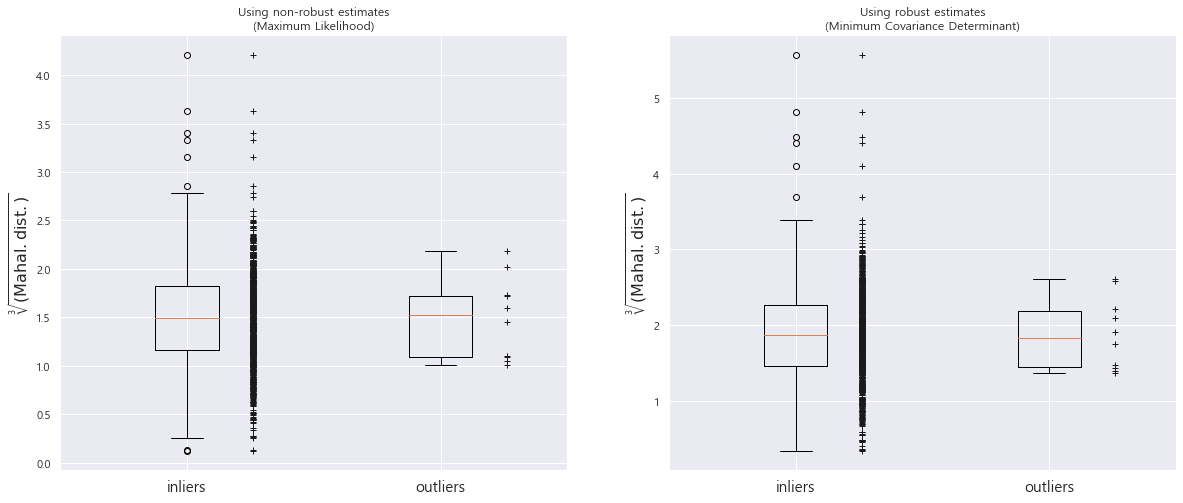

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Calculate cubic root of MLE Mahalanobis distances for samples
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
ax1.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
# Plot individual samples
ax1.plot(np.full(n_samples - n_outliers, 1.26), emp_mahal[:-n_outliers],
         '+k', markeredgewidth=1)
ax1.plot(np.full(n_outliers, 2.26), emp_mahal[-n_outliers:],
         '+k', markeredgewidth=1)
ax1.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax1.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax1.set_title("Using non-robust estimates\n(Maximum Likelihood)")

# Calculate cubic root of MCD Mahalanobis distances for samples
robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
ax2.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
            widths=.25)
# Plot individual samples
ax2.plot(np.full(n_samples - n_outliers, 1.26), robust_mahal[:-n_outliers],
         '+k', markeredgewidth=1)
ax2.plot(np.full(n_outliers, 2.26), robust_mahal[-n_outliers:],
         '+k', markeredgewidth=1)
ax2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax2.set_title("Using robust estimates\n(Minimum Covariance Determinant)")

## 1.8 Isolation anomaly

In [15]:
from sklearn.ensemble import IsolationForest
df = pd.DataFrame(X, columns= ['col'+ str(i+1) for i in range(X.shape[1])])

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df.values.reshape(-1, 1))

anomaly_score = isolation_forest.decision_function(df['col1'].values.reshape(-1, 1))
outlier = isolation_forest.predict(df['col1'].values.reshape(-1, 1))

data = pd.DataFrame(np.c_[anomaly_score, outlier], columns = ['anomaly_score', 'outlier'])
data.reset_index(inplace=True)
data.sample(5)
data['outlier'].value_counts(normalize=True)

IsolationForest()

,index,anomaly_score,outlier
373,373,0.031881,1.0
819,819,0.059326,1.0
785,785,-0.076741,-1.0
439,439,0.051108,1.0
508,508,0.040087,1.0


 1.0    0.614
-1.0    0.386
Name: outlier, dtype: float64

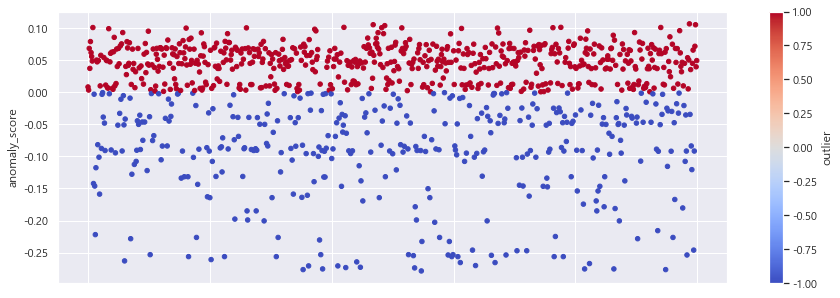

In [16]:
ax2 = data.plot.scatter(x='index', y='anomaly_score',
                        c='outlier',
                        colormap='coolwarm',
                        figsize=(15,5))

# End